In [1]:
import pandas as pd  
import numpy as np
from tqdm import tqdm  
from collections import defaultdict  
import os, math, warnings, math, pickle
from tqdm import tqdm
import faiss
import collections
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss
warnings.filterwarnings('ignore')

### faiss
Embedding的近邻搜索是当前图推荐系统非常重要的一种召回方式，通过item2vec、矩阵分解、双塔DNN等方式都能够产出训练好的user embedding、item embedding，对于embedding的使用非常的灵活：

    - 输入user embedding，近邻搜索item embedding，可以给user推荐感兴趣的items
    - 输入user embedding，近邻搜搜user embedding，可以给user推荐感兴趣的user
    - 输入item embedding，近邻搜索item embedding，可以给item推荐相关的items

然而有一个工程问题，一旦user embedding、item embedding数据量达到一定的程度，对他们的近邻搜索将会变得非常慢，如果离线阶段提前搜索好在高速缓存比如redis存储好结果当然没问题，但是这种方式很不实时，如果能在线阶段上线几十MS的搜索当然效果最好。

Faiss是Facebook AI团队开源的针对聚类和相似性搜索库，为稠密向量提供高效相似度搜索和聚类，支持十亿级别向量的搜索，是目前最为成熟的近似近邻搜索库。

使用faiss的简单流程，内容包括：

    - 读取训练好的Embedding数据
    - 构建faiss索引，将待搜索的Embedding添加进去
    - 取得目标Embedding，实现搜索得到ID列表
    - 根据ID获取电影标题，返回结果

# 多路召回

所谓的<mark>“多路召回”策略，就是指采用不同的策略、特征或简单模型，分别召回一部分候选集；然后把候选集混合在一起供后续排序模型使用；

可以明显的看出，“多路召回策略”是在<mark>“计算速度”和“召回率”之间进行权衡的结果。

其中，各种简单策略保证候选集的快速召回，从不同角度设计的策略保证召回率接近理想的状态，不至于损伤排序效果。

如下图是多路召回的一个示意图，在多路召回中，每个策略之间毫不相关，所以一般可以<mark>写并发多线程同时进行，这样可以更加高效。

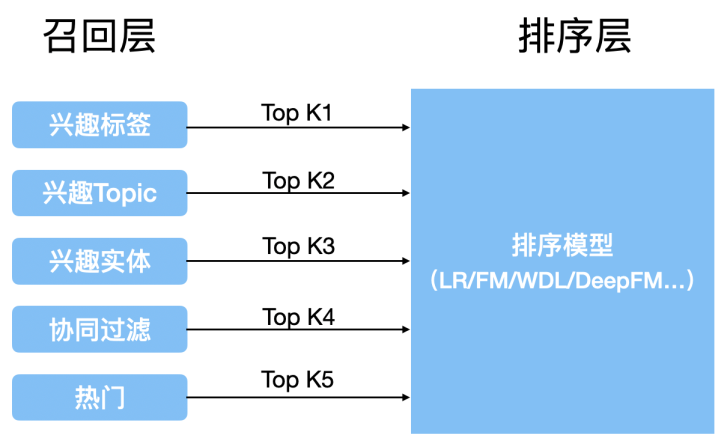

## 读取数据

在一般的推荐系统比赛中读取数据部分主要分为三种模式， 不同的模式对应的不同的数据集：

1. Debug模式： 这个的目的是帮助我们基于数据先搭建一个简易的baseline并跑通， 保证写的baseline代码没有什么问题。 由于推荐比赛的数据往往非常巨大， 如果一上来直接采用全部的数据进行分析，搭建baseline框架， 往往会带来时间和设备上的损耗， 所以这时候我们往往需要从海量数据的训练集中随机抽取一部分样本来进行调试<mark>(train_click_log_sample)， 先跑通一个baseline。
2. 线下验证模式： 这个的目的是帮助我们在线下基于已有的训练集数据， 来选择好合适的模型和一些超参数。 所以我们这一块只需要加载整个训练集<mark>(train_click_log)， 然后把整个训练集再分成训练集和验证集。 训练集是模型的训练数据， 验证集部分帮助我们调整模型的参数和其他的一些超参数。
3. 线上模式： 我们用debug模式搭建起一个推荐系统比赛的baseline， <mark>用线下验证模式选择好了模型和一些超参数， 这一部分就是真正的对于给定的测试集进行预测， 提交到线上， 所以这一块使用的训练数据集是全量的数据集(train_click_log+test_click_log)

下面就分别对这三种不同的数据读取模式先建立不同的代导入函数， 方便后面针对不同的模式下导入数据。

In [2]:
data_path = './data/'
save_path = './results_version3/'

# 做召回评估的一个标志, 如果不进行评估就是直接使用全量数据进行召回
metric_recall = False

In [3]:
# debug模式： 从训练集中划出一部分数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        训练集中采样一部分数据调试
        data_path: 原数据的存储路径
        sample_nums: 采样数目（这里由于机器的内存限制，可以采样用户做）
    """
    all_click = pd.read_csv(data_path + 'train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False) 
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

# 读取点击数据，这里分成线上和线下，如果是为了获取线上提交结果应该讲测试集中的点击数据合并到总的数据中
# 如果是为了线下验证模型的有效性或者特征的有效性，可以只使用训练集
def get_all_click_df(data_path='./data/', offline=True):
    if offline:
        all_click = pd.read_csv(data_path + 'train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + 'train_click_log.csv')
        tst_click = pd.read_csv(data_path + 'testA_click_log.csv')

        all_click = trn_click.append(tst_click)
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

In [4]:
# 读取文章的基本属性 articles.csv
def get_item_info_df(data_path):
    item_info_df = pd.read_csv(data_path + 'articles.csv')
    
    # 为了方便与训练集中的click_article_id拼接 (JOIN)，需要把article_id修改成click_article_id
    item_info_df = item_info_df.rename(columns={'article_id': 'click_article_id'})
    
    return item_info_df

# 读取文章的Embedding数据 articles_emb.csv
def get_item_emb_dict(data_path):
    item_emb_df = pd.read_csv(data_path + 'articles_emb.csv',dtype='float32')
    
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    #item_emb_np = np.array(item_emb_df[item_emb_cols],dtype='float32')
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols],dtype='float32')  
    #ascontiguousarray函数将一个内存不连续存储的数组转换为内存连续存储的数组，使得运行速度更快
    
    # 进行归一化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)

    item_emb_dict = dict(zip(item_emb_df['article_id'], item_emb_np))
    pickle.dump(item_emb_dict, open(save_path + 'item_content_emb.pkl', 'wb'))
    
    return item_emb_dict

In [5]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
# 采样数据
all_click_df = get_all_click_sample(data_path)

# 全量训练集
#all_click_df = get_all_click_df(offline=False)

# 对时间戳进行归一化,用于在关联规则的时候计算权重
all_click_df['click_timestamp'] = all_click_df[['click_timestamp']].apply(max_min_scaler)

In [ ]:
item_info_df = get_item_info_df(data_path) #articles.csv

In [ ]:
#item_emb_dict = get_item_emb_dict(data_path) #articles_embedding.csv

### 工具函数
#### 1. 获取用户-文章-时间函数

这个在基于关联规则的<mark>用户协同过滤的时候会用到

In [ ]:
# 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
def get_user_item_time(click_df):
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    click_df = click_df.sort_values('click_timestamp')
    user_item_time_df = click_df.groupby('user_id')['click_article_id', 'click_timestamp']\
                                .apply(lambda x: make_item_time_pair(x))\
                                .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

#### 2. 获取文章-用户-时间函数

这个在基于关联规则的<mark>文章协同过滤的时候会用到

In [ ]:
# 根据时间获取商品被点击的用户序列  {item1: [(user1, time1), (user2, time2)...]...}
# 这里的时间是用户点击当前商品的时间，好像没有直接的关系。
def get_item_user_time_dict(click_df):
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))
    
    click_df = click_df.sort_values('click_timestamp')
    item_user_time_df = click_df.groupby('click_article_id')['user_id', 'click_timestamp']\
                                .apply(lambda x: make_user_time_pair(x))\
                                .reset_index().rename(columns={0: 'user_time_list'})
    
    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict

#### 3. 获取历史hist_df 和 最后一次点击last_df

这个在评估召回结果， 特征工程和制作标签转成监督学习测试集的时候回用到

In [ ]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    
    all_click = all_click.sort_values(by=['user_id', 'click_timestamp'])
    click_last_df = all_click.groupby('user_id').tail(1) #最后一次点击

    # 如果用户只有一个点击，hist为空了，会导致训练的时候这个用户不可见，此时默认泄露一下
    def hist_func(user_df):
        if len(user_df) == 1:
            return user_df
        else:
            return user_df[:-1] #获取当前数据的历史点击，除了最近一次

    click_hist_df = all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)

    return click_hist_df, click_last_df

#### 4.获取文章属性特征 dict{ article_id : }

In [ ]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段直接使用
def get_item_info_dict(item_info_df):
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_info_df['created_at_ts'] = item_info_df[['created_at_ts']].apply(max_min_scaler) #时间戳归一化
    
    item_type_dict = dict(zip(item_info_df['click_article_id'], item_info_df['category_id']))
    item_words_dict = dict(zip(item_info_df['click_article_id'], item_info_df['words_count']))
    item_created_time_dict = dict(zip(item_info_df['click_article_id'], item_info_df['created_at_ts']))
    
    return item_type_dict, item_words_dict, item_created_time_dict

#### 5. 获取用户历史点击的文章信息

In [ ]:
def get_user_hist_item_info_dict(all_click):
    
    # 获取user_id对应的用户历史点击文章类型的集合字典
    user_hist_item_typs = all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict = dict(zip(user_hist_item_typs['user_id'], user_hist_item_typs['category_id']))
    
    # 获取user_id对应的用户点击文章的集合
    user_hist_item_ids_dict = all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict = dict(zip(user_hist_item_ids_dict['user_id'], user_hist_item_ids_dict['click_article_id']))
    
    # 获取user_id对应的用户历史点击的文章的平均字数字典
    user_hist_item_words = all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict = dict(zip(user_hist_item_words['user_id'], user_hist_item_words['words_count']))
    
    # 获取user_id对应的用户最后一次点击的文章的创建时间
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    
    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'], \
                                                user_last_item_created_time['created_at_ts']))
    
    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict

#### 6. 获取点击次数最多的Top-k个文章

In [ ]:
# 获取近期点击最多的文章
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## 定义多路召回字典

In [ ]:
# 获取文章的属性信息，保存成字典的形式方便查询 {article_id : }
item_type_dict, item_words_dict, item_created_time_dict = get_item_info_dict(item_info_df)

# 定义一个多路召回的字典，将各路召回的结果都保存在这个字典当中
user_multi_recall_dict =  {'itemcf_sim_itemcf_recall': {},
                           'embedding_sim_item_recall': {},
                           'youtubednn_recall': {},
                           'youtubednn_usercf_recall': {}, 
                           'cold_start_recall': {}}

# 提取最后一次点击作为召回评估，如果不需要做召回评估直接使用全量的训练集进行召回(线下验证模型)
# 如果不是召回评估，直接使用全量数据进行召回，不用将最后一次提取出来
trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)

### 召回效果评估

做完了召回有时候也需要对当前的召回方法或者参数进行调整以达到更好的召回效果，因为召回的结果决定了最终排序的上限，下面也会提供一个<mark>召回评估的方法

In [ ]:
# 依次评估召回的前10, 20, 30, 40, 50个文章中的击中率
def metrics_recall(user_recall_items_dict, trn_last_click_df, topk=5):
    last_click_item_dict = dict(zip(trn_last_click_df['user_id'], trn_last_click_df['click_article_id']))
    user_num = len(user_recall_items_dict)
    
    for k in range(10, topk+1, 10):
        hit_num = 0
        for user, item_list in user_recall_items_dict.items():
            # 获取前k个召回的结果
            tmp_recall_items = [x[0] for x in user_recall_items_dict[user][:k]]
            if last_click_item_dict[user] in set(tmp_recall_items): #用户最近一次点击的文章 在recall列表里，则+1
                hit_num += 1
        
        hit_rate = round(hit_num * 1.0 / user_num, 5)
        print(' topk: ', k, ' : ', 'hit_num: ', hit_num, 'hit_rate: ', hit_rate, 'user_num : ', user_num)

## 计算相似性矩阵

这一部分主要是通过协同过滤以及向量检索得到相似性矩阵，<mark>相似性矩阵主要分为user2user和item2item；

### 1. itemCF i2i_sim
获取基于itemCF的item2item的相似性矩阵:

借鉴KDD2020的去偏商品推荐，<mark>在计算item2item相似性矩阵时，使用关联规则，使得计算的文章的相似性还考虑到了:
- 用户点击的时间权重
- 用户点击的顺序权重
- 文章创建的时间权重

In [ ]:
def itemcf_sim(df, item_created_time_dict):
    """
        文章与文章之间的相似性矩阵计算
        :param df: 数据表
        :item_created_time_dict:  文章创建时间的字典
        return : 文章与文章的相似性矩阵
        
        思路: 基于物品的协同过滤(详细请参考上一期推荐系统基础的组队学习) + 关联规则
    """
    
    user_item_time_dict = get_user_item_time(df) #{user_id :{item_id:ts, ...},...}
    
    # 计算物品相似度
    i2i_sim = {}  '''{item_i :{item_j :Wij, ...}, ...} '''
    item_cnt = defaultdict(int)  '''{item_i: cnt, ...}'''
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1, (i, i_click_time) in enumerate(item_time_list):
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for loc2, (j, j_click_time) in enumerate(item_time_list):
                if(i == j): continue    
                # 考虑文章的正向顺序点击和反向顺序点击    
                loc_alpha = 1.0 if loc2 > loc1 else 0.7
                # 位置信息权重，其中的参数可以调节
                loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                # 点击时间权重，其中的参数可以调节
                click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))
                # 两篇文章创建时间的权重，其中的参数可以调节
                created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                i2i_sim[i].setdefault(j, 0)
                # 考虑多种因素的权重计算最终的文章之间的相似度
                i2i_sim[i][j] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)
                '''j在i后面，user点击相隔顺序越近，点击时间间隔越短，创作时间越近，j与i越相似'''
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))
    
    return i2i_sim_

In [ ]:
i2i_sim = itemcf_sim(all_click_df, item_created_time_dict)

### 2. userCF u2u_sim

在计算用户之间的相似度的时候，也可以使用一些简单的<mark>关联规则，比如用户活跃度权重，这里将用户的点击次数作为用户活跃度的指标

In [ ]:
def get_user_activate_degree_dict(all_click_df):
    all_click_df_ = all_click_df.groupby('user_id')['click_article_id'].count().reset_index()
    
    # 用户活跃度归一化
    mm = MinMaxScaler()
    all_click_df_['click_article_id'] = mm.fit_transform(all_click_df_[['click_article_id']])
    user_activate_degree_dict = dict(zip(all_click_df_['user_id'], all_click_df_['click_article_id']))
    
    return user_activate_degree_dict

In [ ]:
def usercf_sim(all_click_df, user_activate_degree_dict):
    """
        用户相似性矩阵计算
        :param all_click_df: 数据表
        :param user_activate_degree_dict: 用户活跃度的字典
        return 用户相似性矩阵
        
        思路: 基于用户的协同过滤(详细请参考上一期推荐系统基础的组队学习) + 关联规则
    """
    item_user_time_dict = get_item_user_time_dict(all_click_df)
    
    u2u_sim = {} #{user_i :{user_j :Wij, ...}, ...} 
    user_cnt = defaultdict(int)
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        for u, click_time in user_time_list:
            user_cnt[u] += 1
            u2u_sim.setdefault(u, {})
            for v, click_time in user_time_list:
                u2u_sim[u].setdefault(v, 0)
                if u == v:
                    continue
                # 用户平均活跃度作为活跃度的权重，这里的式子也可以改善
                '''用户越活跃，相似参数越高'''
                activate_weight = 100 * 0.5 * (user_activate_degree_dict[u] + user_activate_degree_dict[v])   
                u2u_sim[u][v] += activate_weight / math.log(len(user_time_list) + 1)
    
    u2u_sim_ = u2u_sim.copy()
    for u, related_users in u2u_sim.items():
        for v, wij in related_users.items():
            u2u_sim_[u][v] = wij / math.sqrt(user_cnt[u] * user_cnt[v])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(u2u_sim_, open(save_path + 'usercf_u2u_sim.pkl', 'wb'))

    return u2u_sim_

In [ ]:
# 由于usercf计算时候太耗费内存了，这里就不直接运行了
# 如果是采样的话，是可以运行的
user_activate_degree_dict = get_user_activate_degree_dict(all_click_df)
u2u_sim = usercf_sim(all_click_df, user_activate_degree_dict)

### 3. item embedding sim

使用Embedding计算item之间的相似度是为了<mark>后续冷启动的时候可以获取未出现在点击数据中的文章;
- <mark>由于itemCF，userCF 协同过滤 只用到了 user和item的交互信息；而embedding是在学习user和item的latent varaibels

-------------------------------------------------------------------------------------------------
后面有对冷启动专门的介绍，这里简单的说一下<mark>faiss。

faiss是Facebook的AI团队开源的一套用于<mark>做聚类或者相似性搜索的软件库，底层是用C++实现。Faiss因为超级优越的性能，被广泛应用于推荐相关的业务当中.

<mark>faiss工具包一般使用在推荐系统中的向量召回部分。
    
在做向量召回的时候要么是u2u,u2i或者i2i，这里的u和i指的是user和item.我们知道在实际的场景中user和item的数量都是海量的，我们<mark>最容易想到的基于向量相似度的召回就是使用两层循环遍历user列表或者item列表计算两个向量的相似度</mark>，但是这样做在面对海量数据是不切实际的，<mark>faiss就是用来加速计算某个查询向量最相似的topk个索引向量。
    
faiss查询的原理：
- faiss使用了PCA和PQ(Product quantization乘积量化)两种技术进行向量压缩和编码，当然还使用了其他的技术进行优化，但是PCA和PQ是其中最核心部分。
- faiss官方教程： https://github.com/facebookresearch/faiss/wiki/Getting-started

#### 思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 
只不过由于文章数量太多，这里用了faiss进行加速

In [ ]:
# 向量检索相似度计算
# topk指的是每个item, faiss搜索后返回最相似的topk个item
def embdding_sim(click_df, item_emb_df, save_path, topk):
    """
        基于内容的文章embedding相似性矩阵计算
        :param click_df: 数据表
        :param item_emb_df: 文章的embedding
        :param save_path: 保存路径
        :patam topk: 找最相似的topk篇
        return 文章相似性矩阵
        
        思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 只不过由于文章数量太多，这里用了faiss进行加速
    """
    
    # 文章索引与文章id的字典映射
    item_idx_2_rawid_dict = dict(zip(item_emb_df.index, item_emb_df['article_id']))
    
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)
    # 向量进行单位化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)
    
    # 建立faiss索引
    item_index = faiss.IndexFlatIP(item_emb_np.shape[1])
    item_index.add(item_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = item_index.search(item_emb_np, topk) # 返回的是列表
    
    # 将向量检索的结果保存成原始id的对应关系
    item_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_emb_np)), sim, idx)):
        target_raw_id = item_idx_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_idx_2_rawid_dict[rele_idx]
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(item_sim_dict, open(save_path + 'emb_i2i_sim.pkl', 'wb'))   
    
    return item_sim_dict

In [ ]:
#item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
#emb_i2i_sim = embdding_sim(all_click_df, item_emb_df, save_path, topk=10) # topk可以自行设置

# 召回

这个就是我们开篇提到的那个问题， 面的36万篇文章， 20多万用户的推荐， 我们又有哪些策略来缩减问题的规模？ 我们就可以再召回阶段筛选出用户对于点击文章的候选集合， 从而降低问题的规模。召回常用的策略：

- Youtube DNN 召回
- 基于文章的召回
    - 文章的协同过滤
    - 基于文章embedding的召回
- 基于用户的召回
    - 用户的协同过滤
    - 用户embedding

上面的各种召回方式
- 一部分在<mark>基于用户已经看得文章的基础上去召回与这些文章相似的一些文章</mark>，而这个相似性的计算方式不同， 就得到了不同的召回方式， 比如文章的协同过滤， 文章内容的embedding等。
- 一部分是根据<mark>用户的相似性进行推荐，对于某用户推荐与其相似的其他用户看过的文章</mark>，比如用户的协同过滤和用户embedding。 
- 还有一种思路是<mark>类似矩阵分解（隐向量）的思路，先计算出用户和文章的embedding之后，就可以直接算用户和文章的相似度</mark>， 根据这个相似度进行推荐， 比如YouTube DNN。

### 获取双塔召回时的训练验证数据

- train_set 构造正负样本 <mark>[user_id, his_item之前看过的所有article, 最后点击正样本/随便一个负样本, label, len(his_item)]
- test_set 将最长的那一个序列长度作为测试数据

In [26]:
# 获取双塔召回时的训练验证数据
# negsample指的是通过滑窗构建样本的时候，负样本的数量
def gen_data_set(data, negsample=0):
    #data :user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
    data.sort_values("click_timestamp", inplace=True)
    item_ids = data['click_article_id'].unique()

    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['click_article_id'].tolist()
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))   # 用户没看过的文章里面选择负样本
            neg_list = np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True)  
            # 对于每个正样本，选择n个负样本
        # 长度只有一个的时候，需要把这条数据也放到训练集中，不然的话最终学到的embedding就会有缺失
        if len(pos_list) == 1:
            train_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            test_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
        # 滑窗构造正负样本
        for i in range(1, len(pos_list)): #对于每一个user点击过的article
            hist = pos_list[:i] #看这个article之前，点击过的所有article
            if i != len(pos_list) - 1:
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1])))  
                '''正样本 [user_id, his_item之前看过的所有article, pos_item这次点击的article, label ‘1’, len(his_item)]'''
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0,len(hist[::-1]))) 
                '''负样本 [user_id, his_item之前看过的所有article, neg_item随便一个负样本, label ‘0’, len(his_item)]'''
            else:
                # 将最长的那一个序列长度作为测试数据
                test_set.append((reviewerID, hist[::-1], pos_list[i],1,len(hist[::-1])))
                
    random.shuffle(train_set)
    random.shuffle(test_set)
    return train_set, test_set

# 将输入的数据进行padding，使得序列特征的长度都一致
def gen_model_input(train_set,user_profile,seq_max_len):

    train_uid = np.array([line[0] for line in train_set])
    train_seq = [line[1] for line in train_set]
    train_iid = np.array([line[2] for line in train_set])
    train_label = np.array([line[3] for line in train_set])
    train_hist_len = np.array([line[4] for line in train_set])
    #list 变 dict
    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    train_model_input = {"user_id": train_uid, "click_article_id": train_iid, "hist_article_id": train_seq_pad,
                         "hist_len": train_hist_len}

    return train_model_input, train_label

In [32]:
type(all_click_df["user_id"]),type(all_click_df[["user_id"]]) #DataFrame比series 多了上方的col name

(pandas.core.series.Series, pandas.core.frame.DataFrame)

## 1. YoutubeDNN召回

直接获取用户召回的候选文章列表;
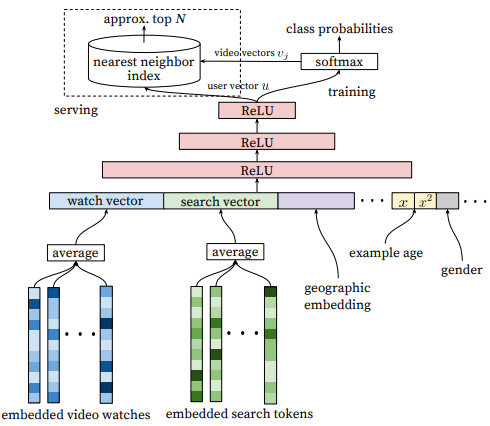

<mark>定义一个YoutubeDNN模型：
1. 分别传入<mark>用户侧特征列表user_feature_columns和物品侧特征列表item_feature_columns；
2. 然后<mark>配置优化器和损失函数
3. 开始进行训练, 梯度下降求优化参数；
    
    
4. 训练完模型之后,提取训练的Embedding，包括<mark>user Embedding端和item Embedding端；
5. <mark>online时faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item；

=> YoutubeDNN直接通过向量的方式得到了召回结果, user Embedding和item Embedding;
    
=> <mark>只有Youtube用监督学习的方法，创造正负样本，最小损失函数，目的是学习出user Embedding和item Embedding;

=> 相比于<mark>上面的召回方法，先得到i2i及u2u的相似性矩阵，再进行协同过滤召回才能得到召回结果

In [2]:
def youtubednn_u2i_dict(data, topk=20):    
    sparse_features = ["click_article_id", "user_id"]
    SEQ_LEN = 30 # 用户点击序列的长度，短的填充，长的截断
    
    user_profile_ = data[["user_id"]].drop_duplicates('user_id')
    item_profile_ = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    # 类别编码，
    features = ["click_article_id", "user_id"]
    feature_max_idx = {}
    
    for feature in features:
        lbe = LabelEncoder() #LabelEncoder 将一列文本数据转化成数值；OneHotEncoder 将一列文本数据转化成一列或多列只有0和1的数据。
        data[feature] = lbe.fit_transform(data[feature])
        feature_max_idx[feature] = data[feature].max() + 1
    
    # 提取user和item的画像，这里具体选择哪些特征还需要进一步的分析和考虑
    user_profile = data[["user_id"]].drop_duplicates('user_id')
    item_profile = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    user_index_2_rawid = dict(zip(user_profile['user_id'], user_profile_['user_id']))
    item_index_2_rawid = dict(zip(item_profile['click_article_id'], item_profile_['click_article_id']))
    
    # 划分训练和测试集
    # 由于深度学习需要的数据量通常都是非常大的，所以为了保证召回的效果，往往会通过滑窗的形式扩充训练样本
    train_set, test_set = gen_data_set(data, 0)
    # 整理输入数据，具体的操作可以看上面的函数
    train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
    test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)
    
    # 确定Embedding的维度
    embedding_dim = 16
    
    # 将数据整理成模型可以直接输入的形式
    '''构建deepctr的特征列，主要分为两类特征，
    一是定长的SparseFeat，稀疏的类别特征，
    二是可变长度的VarLenSparseFeat，像genres这样的包含多个的。'''
    #SparseFeat(特征名称, vocabulary_size, embedding_dim, embedding_name )
    #VarLenSparseFeat(SparseFeat 一个系数特征的实例, maxLen, 池化方法， 特征长度名称)
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_article_id', feature_max_idx['click_article_id']\
                                                        , embedding_dim, embedding_name="click_article_id")\
                                             ,SEQ_LEN, 'mean', 'hist_len'),]
    item_feature_columns = [SparseFeat('click_article_id', feature_max_idx['click_article_id'], embedding_dim)]
    
    # 模型的定义 
    # num_sampled: 负采样时的样本数量
    '''定义一个YoutubeDNN模型，
    分别传入用户侧特征列表user_feature_columns和物品侧特征列表item_feature_columns。
    然后配置优化器和损失函数，开始进行训练。'''
    model = YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, user_dnn_hidden_units=(64, embedding_dim))
    # 模型编译
    model.compile(optimizer="adam", loss=sampledsoftmaxloss)  
    
    # 模型训练，这里可以定义验证集的比例，如果设置为0的话就是全量数据直接进行训练
    history = model.fit(train_model_input, train_label, batch_size=256, epochs=1, verbose=1, validation_split=0.0)
    
    # 训练完模型之后,提取训练的Embedding，包括user端和item端
    test_user_model_input = test_model_input
    all_item_model_input = {"click_article_id": item_profile['click_article_id'].values}

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
    
    # 保存当前的item_embedding 和 user_embedding 排序的时候可能能够用到，但是需要注意保存的时候需要和原始的id对应
    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)
    
    # embedding保存之前归一化一下
    user_embs = user_embs / np.linalg.norm(user_embs, axis=1, keepdims=True)
    item_embs = item_embs / np.linalg.norm(item_embs, axis=1, keepdims=True)
    
    # 将Embedding转换成字典的形式方便查询
    raw_user_id_emb_dict = {user_index_2_rawid[k]: \
                                v for k, v in zip(user_profile['user_id'], user_embs)}
    raw_item_id_emb_dict = {item_index_2_rawid[k]: \
                                v for k, v in zip(item_profile['click_article_id'], item_embs)}
    # 将Embedding保存到本地
    pickle.dump(raw_user_id_emb_dict, open(save_path + 'user_youtube_emb.pkl', 'wb'))
    pickle.dump(raw_item_id_emb_dict, open(save_path + 'item_youtube_emb.pkl', 'wb'))
    
    # faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item
    index = faiss.IndexFlatIP(embedding_dim)
    # 上面已经进行了归一化，这里可以不进行归一化了
#     faiss.normalize_L2(user_embs)
#     faiss.normalize_L2(item_embs)
    index.add(item_embs) # 将item向量构建索引
    sim, idx = index.search(np.ascontiguousarray(user_embs), topk) # 通过user去查询最相似的topk个item
    
    user_recall_items_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(test_user_model_input['user_id'], sim, idx)):
        target_raw_id = user_index_2_rawid[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index_2_rawid[rele_idx]
            user_recall_items_dict[target_raw_id][rele_raw_id] = user_recall_items_dict.get(target_raw_id, {})\
                                                                    .get(rele_raw_id, 0) + sim_value
            
    user_recall_items_dict = {k: sorted(v.items(), key=lambda x: x[1], reverse=True) for k, v in user_recall_items_dict.items()}
    # 将召回的结果进行排序
    
    # 保存召回的结果
    # 这里是直接通过向量的方式得到了召回结果，相比于上面的召回方法，上面的只是得到了i2i及u2u的相似性矩阵，还需要进行协同过滤召回才能得到召回结果
    # 可以直接对这个召回结果进行评估，为了方便可以统一写一个评估函数对所有的召回结果进行评估
    pickle.dump(user_recall_items_dict, open(save_path + 'youtube_u2i_dict.pkl', 'wb'))
    return user_recall_items_dict

In [3]:
if not metric_recall:
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(all_click_df, topk=20)
else:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(trn_hist_click_df, topk=20)
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['youtubednn_recall'], trn_last_click_df, topk=20)

NameError: name 'metric_recall' is not defined

## 2. itemCF recall
上面已经通过协同过滤，Embedding检索的方式得到了文章的相似度矩阵，

<mark> 遍历这个user看过的所有hist文章，对于每一个文章，遍历它的相似度矩阵，对它没有看过的文章做评分，评分累加；
    
下面使用协同过滤的思想，给用户召回与其历史文章相似的文章.(这里在召回的时候，也是用了关联规则的方式)
- 考虑相似文章与历史点击文章顺序的权重(细节看代码)
- 考虑文章创建时间的权重，也就是考虑相似文章与历史点击文章创建时间差的权重
- 考虑文章内容相似度权重(使用Embedding计算相似文章相似度，但是这里需要注意，在Embedding的时候并没有计算所有商品两两之间的相似度，所以相似的文章与历史点击文章不存在相似度，需要做特殊处理)

In [ ]:
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
        
    """
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items }

    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue
            
            # 文章创建时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重
            loc_weight = (0.9 ** (len(user_hist_items) - loc))
            
            content_weight = 1.0
            if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                content_weight += emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                content_weight += emb_i2i_sim[j][i]
                
            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items(): # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

In [ ]:
# 先进行itemcf召回, 为了召回评估，所以提取最后一次点击
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))
emb_i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, \
                                                        i2i_sim, sim_item_topk, recall_item_num, \
                                                        item_topk_click, item_created_time_dict, emb_i2i_sim)

user_multi_recall_dict['itemcf_sim_itemcf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['itemcf_sim_itemcf_recall'], open(save_path + 'itemcf_recall_dict.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['itemcf_sim_itemcf_recall'], trn_last_click_df, topk=recall_item_num)

## 3. Item embedding sim 召回

In [ ]:
# 这里是为了召回评估，所以提取最后一次点击
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb')) #与召回2路的区别！！! Item相似矩阵的区别

sim_item_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, \
                                                        i2i_sim, sim_item_topk, recall_item_num, \
                                                        item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['embedding_sim_item_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['embedding_sim_item_recall'], open(save_path + 'embedding_sim_item_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['embedding_sim_item_recall'], trn_last_click_df, topk=recall_item_num)

## 4. userCF召回 (没有加入多路）
基于用户协同过滤，核心思想是<mark>给用户推荐与其相似的用户历史点击文章，
    
<mark>遍历u2u相似度矩阵，遍历相似用户看过的文章，对user没看过的文章进行打分，分数由u2u相似度以及i2i关联规则相乘，且分数双重遍历中累加；
    
因为这里涉及到了相似用户的历史文章，这里仍然可以加上一些<mark>关联规则来给用户可能点击的文章进行加权:
- 考虑相似用户的历史点击文章与被推荐用户历史点击商品的关系权重
- 而这里的关系就可以直接借鉴基于物品的协同过滤相似的做法，
- 只不过这里是<mark>对被推荐物品关系的一个累加的过程;
- 计算<mark>被推荐用户历史点击文章与相似用户历史点击文章的相似度，文章创建时间差，相对位置的总和，作为各自的权重

In [ ]:
# 基于用户的召回 u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num, 
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param u2u_sim: 字典，文章相似性矩阵
        :param sim_user_topk: 整数， 选择与当前用户最相似的前k个用户
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param item_created_time_dict: 文章创建时间列表
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 历史交互
    user_item_time_list = user_item_time_dict[user_id]    # {item1: time1, item2: time2...}
    user_hist_items = set([i for i, t in user_item_time_list])   # 存在一个用户与某篇文章的多次交互， 这里得去重
    
    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)
            
            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0
            
            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # 内容相似性权重
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]
                # 创建时间差权重
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                
            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv
        
    # 热度补全
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank.items(): # 填充的item应该不在原来的列表中
                continue
            items_rank[item] = - i - 100 # 随便给个复数就行
            if len(items_rank) == recall_item_num:
                break
        
    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]    
    
    return items_rank

In [ ]:
# 这里是为了召回评估，所以提取最后一次点击
# 由于usercf中计算user之间的相似度的过程太费内存了，全量数据这里就没有跑，跑了一个采样之后的数据
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df
    
user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

u2u_sim = pickle.load(open(save_path + 'usercf_u2u_sim.pkl', 'rb')) #u2u_sim!!

sim_user_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)    

pickle.dump(user_recall_items_dict, open(save_path + 'usercf_u2u2i_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_recall_items_dict, trn_last_click_df, topk=recall_item_num)

## 5. user embedding sim召回

虽然没有直接跑usercf的计算用户之间的相似度，为了验证上述基于用户的协同过滤的代码;

下面使用了<mark>YoutubeDNN过程中产生的user embedding来进行向量检索每个user最相似的topk个user，

在使用这里得到的u2u的相似性矩阵，使用usercf进行召回，具体代码如下

In [ ]:
# 使用Embedding的方式获取u2u的相似性矩阵
# topk指的是每个user, faiss搜索后返回最相似的topk个user
def u2u_embdding_sim(click_df, user_emb_dict, save_path, topk):
    
    user_list = []
    user_emb_list = []
    for user_id, user_emb in user_emb_dict.items():
        user_list.append(user_id)
        user_emb_list.append(user_emb)
        
    user_index_2_rawid_dict = {k: v for k, v in zip(range(len(user_list)), user_list)}    
    
    user_emb_np = np.array(user_emb_list, dtype=np.float32)
    
    # 建立faiss索引
    user_index = faiss.IndexFlatIP(user_emb_np.shape[1])
    user_index.add(user_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = user_index.search(user_emb_np, topk) # 返回的是列表
   
    # 将向量检索的结果保存成原始id的对应关系
    user_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(user_emb_np)), sim, idx)):
        target_raw_id = user_index_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = user_index_2_rawid_dict[rele_idx]
            user_sim_dict[target_raw_id][rele_raw_id] = user_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(user_sim_dict, open(save_path + 'youtube_u2u_sim.pkl', 'wb'))   
    return user_sim_dict

In [ ]:
# 读取YoutubeDNN过程中产生的user embedding, 然后使用faiss计算用户之间的相似度
# 这里需要注意，这里得到的user embedding其实并不是很好，因为YoutubeDNN中使用的是用户点击序列来训练的user embedding,
# 如果序列普遍都比较短的话，其实效果并不是很好
user_emb_dict = pickle.load(open(save_path + 'user_youtube_emb.pkl', 'rb'))
u2u_sim = u2u_embdding_sim(all_click_df, user_emb_dict, save_path, topk=10)
'''通过YoutubeDNN得到 u2u_sim '''

In [ ]:
# 使用召回评估函数验证当前召回方式的效果
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
u2u_sim = pickle.load(open(save_path + 'youtube_u2u_sim.pkl', 'rb'))

sim_user_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['youtubednn_usercf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['youtubednn_usercf_recall'], open(save_path + 'youtubednn_usercf_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['youtubednn_usercf_recall'], trn_last_click_df, topk=recall_item_num)

## 冷启动问题
冷启动问题可以分成三类：<mark>文章冷启动，用户冷启动，系统冷启动。

- 文章冷启动：对于一个平台系统新加入的文章，该文章没有任何的交互记录，如何推荐给用户的问题。(对于我们场景可以认为是，日志数据中没有出现过的文章都可以认为是冷启动的文章)
- 用户冷启动：对于一个平台系统新来的用户，该用户还没有文章的交互信息，如何给该用户进行推荐。(对于我们场景就是，测试集中的用户是否在测试集对应的log数据中出现过，如果没有出现过，那么可以认为该用户是冷启动用户。但是有时候并没有这么严格，我们也可以自己设定某些指标来判别哪些用户是冷启动用户，比如通过使用时长，点击率，留存率等等)
- 系统冷启动：就是对于一个平台刚上线，还没有任何的相关历史数据，此时就是系统冷启动，其实也就是前面两种的一个综合。

当前场景下冷启动问题的分析：

1. 对当前的数据进行分析会发现，<mark>日志中所有出现过的点击文章只有3w多个，而整个文章库中却有30多万</mark>，那么测试集中的用户最后一次点击是否会点击没有出现在日志中的文章呢？
    - <mark>如果存在这种情况，说明用户点击的文章之前没有任何的交互信息，这也就是我们所说的文章冷启动。
2. 通过数据分析还可以发现，<mark>测试集用户只有一次点击的数据占得比例还不少</mark>，其实仅仅通过用户的一次点击就给用户推荐文章使用模型的方式也是比较难的，
    - 这里其实也可以考虑用户冷启动的问题，但是这里只给出物品冷启动的一些解决方案及代码，关于用户冷启动的话提一些可行性的做法。
    
    
====================================================================================================
1. 文章冷启动(没有冷启动的探索问题)
其实我们这里不是为了做文章的冷启动而做冷启动，而是<mark>猜测用户可能会点击一些没有在log数据中出现的文章</mark>，我们要做的就是如何从将近27万的文章中选择一些文章作为用户冷启动的文章，这里其实也可以看成是一种召回策略，我们这里就采用简单的比较好理解的基于规则的召回策略来获取用户可能点击的未出现在log数据中的文章。
现在的问题变成了：<mark>如何给每个用户考虑从27万个商品中获取一小部分商品？</mark>随机选一些可能是一种方案。下面给出一些参考的方案。
- 首先<mark>基于Embedding召回一部分与用户历史相似的文章
- 从基于Embedding召回的文章中<mark>通过一些规则过滤掉一些文章，使得留下的文章用户更可能点击</mark>。我们这里的规则，可以是，留下那些与用户历史点击文章主题相同的文章，或者字数相差不大的文章。并且留下的文章尽量是与测试集用户最后一次点击时间更接近的文章，或者是当天的文章也行。
2. 用户冷启动
这里对测试集中的用户点击数据进行分析会发现，测试集中有百分之20的用户只有一次点击，那么<mark>这些点击特别少的用户的召回是不是可以单独做一些策略上的补充呢?</mark> 或者是在排序后直接基于规则加上一些文章呢？这些都可以去尝试，这里没有提供具体的做法。
    
注意：
    
这里看似和基于embedding计算的item之间相似度然后做itemcf是一致的，但是现在我们的目的不一样，我们这里的<mark> 目的是找到相似的向量，并且还没有出现在log日志中的商品，</mark> 再加上一些其他的冷启动的策略，这里需要找回的数量会偏多一点，不然被筛选完之后可能都没有文章了

In [ ]:
# 先进行embedding i2i相似度矩阵（与user item交互无关），再协同滤波itemcf召回
#这里不需要做召回评估，这里只是一种策略
trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb'))

sim_item_topk = 150
recall_item_num = 100 # 稍微召回多一点文章，便于后续的规则筛选

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, 
                                                        recall_item_num, item_topk_click,item_created_time_dict, emb_i2i_sim)
pickle.dump(user_recall_items_dict, open(save_path + 'cold_start_items_raw_dict.pkl', 'wb'))

In [ ]:
# 基于规则进行文章过滤
# 保留文章主题与用户历史浏览主题相似的文章
# 保留文章字数与用户历史浏览文章字数相差不大的文章
# 保留最后一次点击当天的文章
# 按照相似度返回最终的结果

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                     user_last_item_created_time_dict, item_type_dict, item_words_dict, 
                     item_created_time_dict, click_article_ids_set, recall_item_num):
    """
        冷启动的情况下召回一些文章
        :param user_recall_items_dict: 基于内容embedding相似性召回来的很多文章， 字典， {user1: [item1, item2, ..], }
        :param user_hist_item_typs_dict: 字典， 用户点击的文章的主题映射
        :param user_hist_item_words_dict: 字典， 用户点击的历史文章的字数映射
        :param user_last_item_created_time_idct: 字典，用户点击的历史文章创建时间映射
        :param item_tpye_idct: 字典，文章主题映射
        :param item_words_dict: 字典，文章字数映射
        :param item_created_time_dict: 字典， 文章创建时间映射
        :param click_article_ids_set: 集合，用户点击过得文章, 也就是日志里面出现过的文章
        :param recall_item_num: 召回文章的数量， 这个指的是没有出现在日志里面的文章数量
    """
    
    cold_start_user_items_dict = {}
    for user, item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user, [])
        for item, score in item_list:
            # 获取历史文章信息
            hist_item_type_set = user_hist_item_typs_dict[user]
            hist_mean_words = user_hist_item_words_dict[user]
            hist_last_item_created_time = user_last_item_created_time_dict[user]
            hist_last_item_created_time = datetime.fromtimestamp(hist_last_item_created_time)
            
            # 获取当前召回文章的信息
            curr_item_type = item_type_dict[item]
            curr_item_words = item_words_dict[item]
            curr_item_created_time = item_created_time_dict[item]
            curr_item_created_time = datetime.fromtimestamp(curr_item_created_time)

            # 首先，文章不能出现在用户的历史点击中， 然后根据文章主题，文章单词数，文章创建时间进行筛选
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words - hist_mean_words) > 200 or \
                abs((curr_item_created_time - hist_last_item_created_time).days) > 90: 
                continue
                
            cold_start_user_items_dict[user].append((item, score))#user1: [(item1, score1), (item2, score2)..]...}
    
    # 需要控制一下冷启动召回的数量
    cold_start_user_items_dict = {k: sorted(v, key=lambda x:x[1], reverse=True)[:recall_item_num] \
                                  for k, v in cold_start_user_items_dict.items()}
    
    pickle.dump(cold_start_user_items_dict, open(save_path + 'cold_start_user_items_dict.pkl', 'wb'))
    
    return cold_start_user_items_dict

In [ ]:
all_click_df_ = all_click_df.copy()
all_click_df_ = all_click_df_.merge(item_info_df, how='left', on='click_article_id')
user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict = get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_click_df)
# 需要注意的是
# 这里使用了很多规则来筛选冷启动的文章，所以前面再召回的阶段就应该尽可能的多召回一些文章，否则很容易被删掉
cold_start_user_items_dict = cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)

user_multi_recall_dict['cold_start_recall'] = cold_start_user_items_dict

## 多路召回合并
多路召回合并就是将前面所有的召回策略得到的用户文章列表合并起来，下面是对前面所有召回结果的汇总

1. 基于itemcf计算的item之间的相似度sim进行的召回
2. 基于embedding搜索得到的item之间的相似度进行的召回
3. YoutubeDNN召回
4. YoutubeDNN得到的user之间的相似度进行的召回
5. 基于冷启动策略的召回

注意：
在做召回评估的时候就会发现有些召回的效果不错有些召回的效果很差，所以<mark>对每一路召回的结果，我们可以认为的定义一些权重，来做最终的相似度融合

In [ ]:
def combine_recall_results(user_multi_recall_dict, weight_dict=None, topk=25):
    final_recall_items_dict = {}
    
    # 对每一种召回结果按照用户进行归一化，方便后面多种召回结果，相同用户的物品之间权重相加
    def norm_user_recall_items_sim(sorted_item_list):
        # 如果冷启动中没有文章或者只有一篇文章，直接返回，出现这种情况的原因可能是冷启动召回的文章数量太少了，
        # 基于规则筛选之后就没有文章了, 这里还可以做一些其他的策略性的筛选
        if len(sorted_item_list) < 2:
            return sorted_item_list
        
        min_sim = sorted_item_list[-1][1]
        max_sim = sorted_item_list[0][1]
        
        norm_sorted_item_list = []
        for item, score in sorted_item_list:
            if max_sim > 0:
                norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
            else:
                norm_score = 0.0
            norm_sorted_item_list.append((item, norm_score))
            
        return norm_sorted_item_list
    
    print('多路召回合并...')
    for method, user_recall_items in tqdm(user_multi_recall_dict.items()):
        print(method + '...')
        # 在计算最终召回结果的时候，也可以为每一种召回结果设置一个权重
        if weight_dict == None:
            recall_method_weight = 1
        else:
            recall_method_weight = weight_dict[method]
        
        for user_id, sorted_item_list in user_recall_items.items(): # 进行归一化
            user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)
        
        for user_id, sorted_item_list in user_recall_items.items():
            # print('user_id')
            final_recall_items_dict.setdefault(user_id, {})
            for item, score in sorted_item_list:
                final_recall_items_dict[user_id].setdefault(item, 0)
                final_recall_items_dict[user_id][item] += recall_method_weight * score  
    
    final_recall_items_dict_rank = {}
    # 多路召回时也可以控制最终的召回数量
    for user, recall_item_dict in final_recall_items_dict.items():
        final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

    # 将多路召回后的最终结果字典保存到本地
    pickle.dump(final_recall_items_dict_rank, open(os.path.join(save_path, 'final_recall_items_dict.pkl'),'wb'))

    return final_recall_items_dict_rank

In [ ]:
# 这里直接对多路召回的权重给了一个相同的值，其实可以根据前面召回的情况来调整参数的值
weight_dict = {'itemcf_sim_itemcf_recall': 1.0,
               'embedding_sim_item_recall': 1.0,
               'youtubednn_recall': 1.0,
               'youtubednn_usercf_recall': 1.0, 
               'cold_start_recall': 1.0}

In [ ]:
# 最终合并之后每个用户召回150个商品进行排序
final_recall_items_dict_rank = combine_recall_results(user_multi_recall_dict, weight_dict, topk=150)

## 总结
上述实现了如下召回策略：

1. 基于关联规则的itemcf
2. 基于关联规则的usercf
3. youtubednn召回
4. 冷启动召回

对于上述实现的召回策略其实都不是最优的结果，我们只是做了个简单的尝试，其中还有很多地方可以<mark>优化，包括已经实现的这些召回策略的参数或者新加一些，修改一些关联规则都可以。
    
当然还可以尝试<mark>更多的召回策略，比如对新闻进行热度召回等等。